In [1]:
import stockdatalib as sd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas.plotting as pdplt
import warnings
import itertools
#from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# Set the data directory and the stock name
sd.set_data_directory('./data/')

# Update stock data from the remote sources
sd.UpdateStockData('tsla')

# Set stock name for analysis
sd.set_stock('tsla')

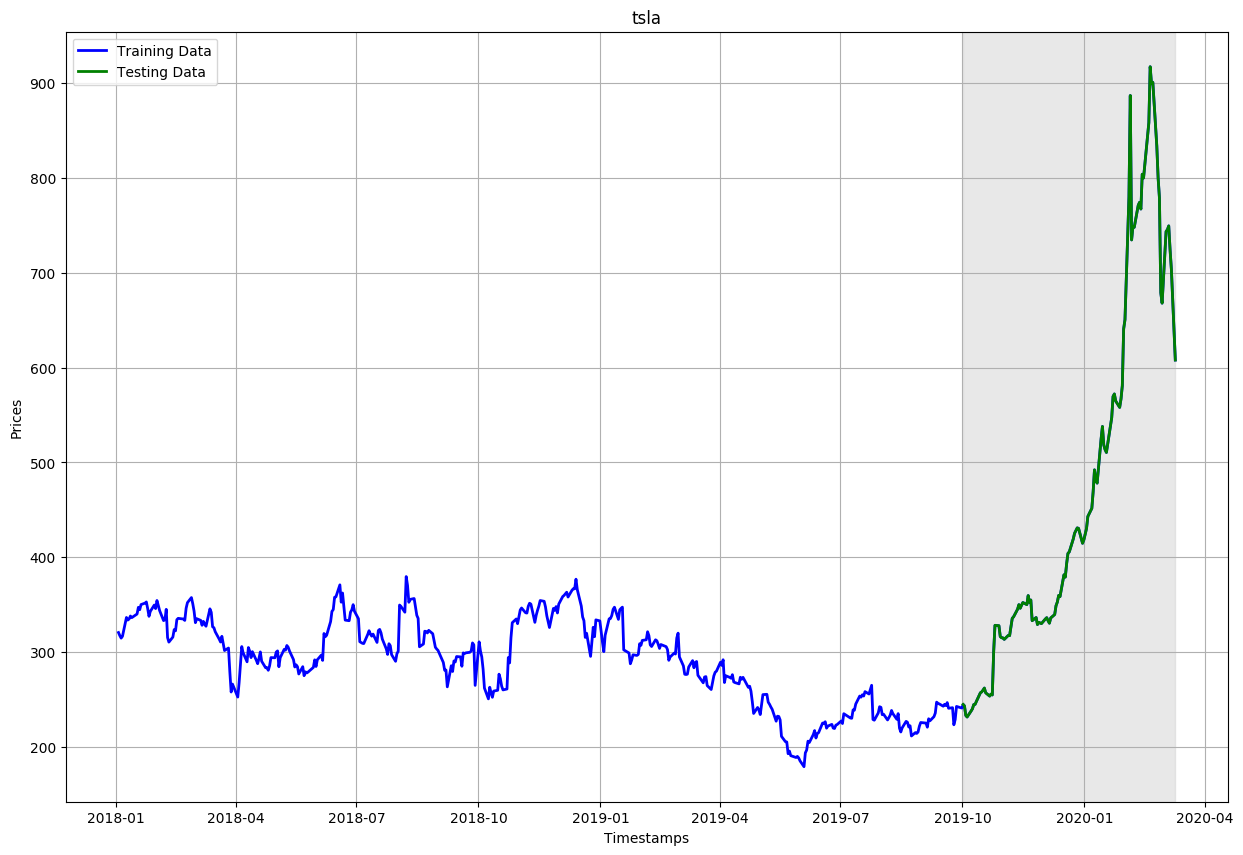

In [3]:
plt.style.use('default')

open_close = 'AdjClose'
price_df = sd.GetStockDataFrame('tsla')
price_df = sd.DatesRange(price_df, '2018-01-01')
df = price_df.copy(deep=True)

#split price dataframe into Training set and Test set, 80% to 20%
train_data = df[0:int(len(df)*0.8)].copy()
test_data  = df[int(len(df)*0.8):].copy()

plt.figure(figsize=(15,10))
plt.title(sd.get_stock())
plt.xlabel('Timestamps')
plt.ylabel('Prices')
plt.plot(df[open_close], 'blue', label='Training Data',lw=2.0)
plt.plot(test_data[open_close], 'green', label='Testing Data',lw=2.0)

plt.axvspan(test_data.index[0], test_data.index[-1], alpha=0.5, color='lightgray')

plt.legend()
plt.grid()

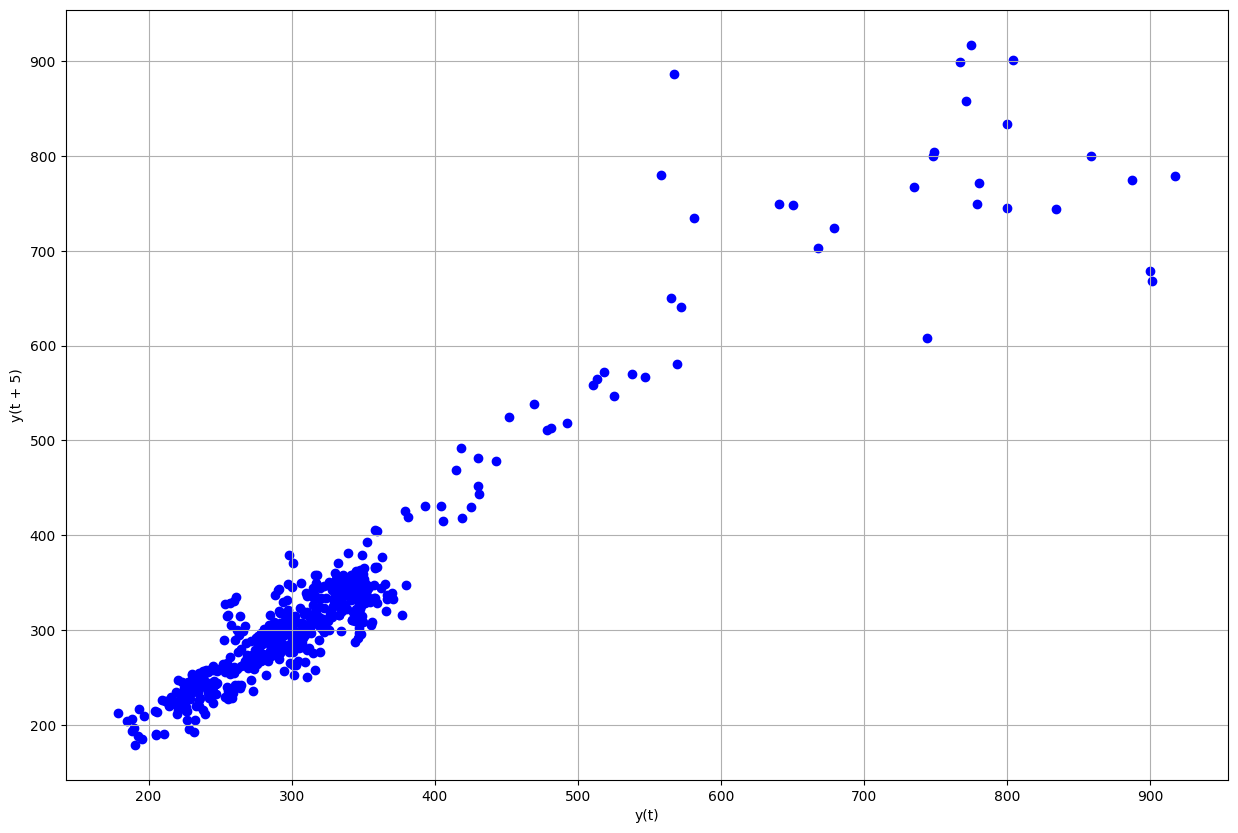

In [4]:
plt.figure(figsize=(15,10))
plt.grid()
pdplt.lag_plot(df['AdjClose'], lag=5,c='b')

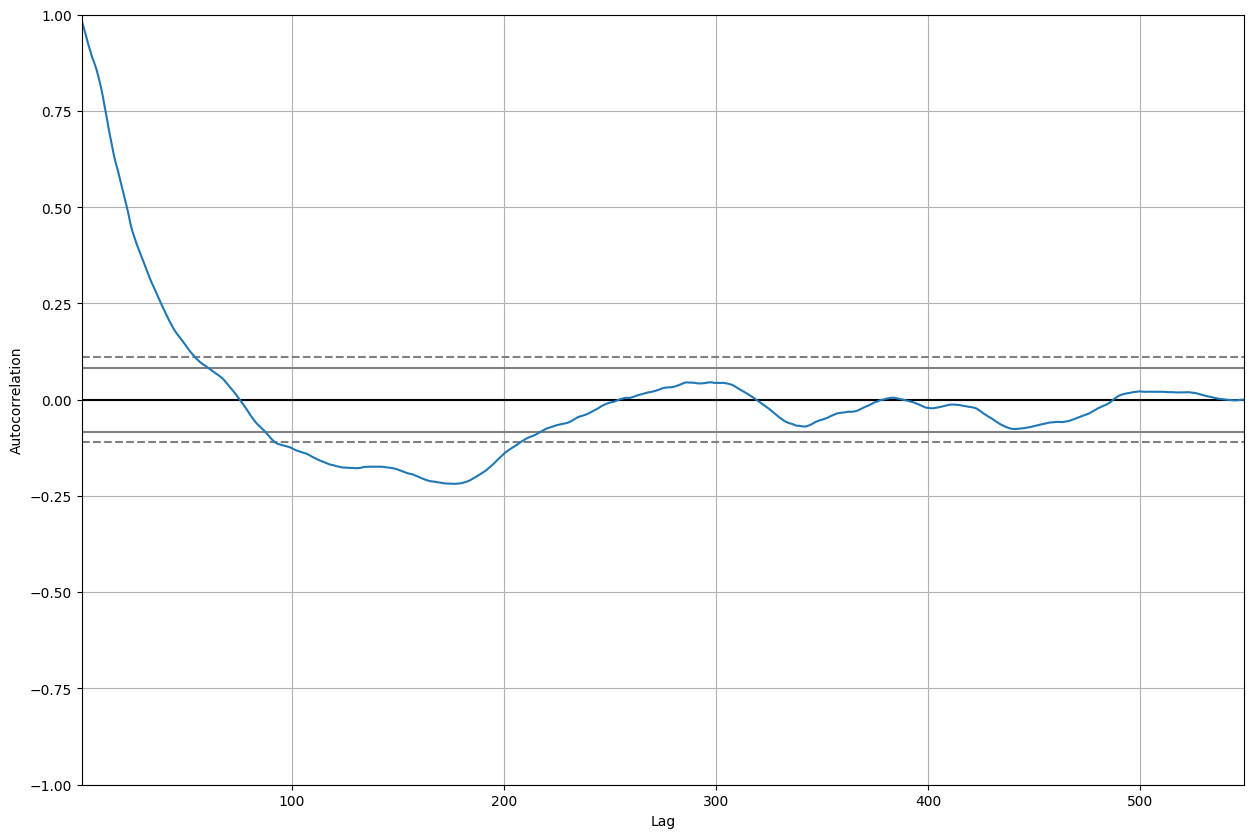

In [5]:
plt.figure(figsize=(15,10))
pdplt.autocorrelation_plot(df[open_close])


In [6]:
def mySMAPE(y_test, y_pred):
    r =  np.mean((200 * (np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred))))) 
    return r

def PredictNextPrice(best_pdq):
    model = ARIMA(history, order=best_pdq)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    return yhat[0]

train_ar = train_data[open_close].values
test_ar = test_data[open_close].values
history = [x for x in train_ar]

# p,d,q params for the ARIMA function
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

warnings.filterwarnings("ignore") # specify to ignore warning messages

dict = [{}]        
for param in pdq:
    try:
        model = ARIMA(history, order=param)
        model_fit = model.fit(disp=0)
        dict.append({"pdq" : param, "AIC" : float(model_fit.aic)})
        r_df.append(dict)
        #print(param)
        #print(model_fit.summary().tables[1])
    except:
        continue

r_df = pd.DataFrame(dict).dropna()  
min_AIC = r_df[ r_df.AIC == r_df.AIC.min() ]
#print(min_AIC)
best_pdq = min_AIC['pdq'].iloc[0]
print("Best order : ",best_pdq)

Best order :  (0, 1, 1)


In [7]:
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=best_pdq)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = mySMAPE(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 1027.355
Symmetric mean absolute percentage error: 43.321


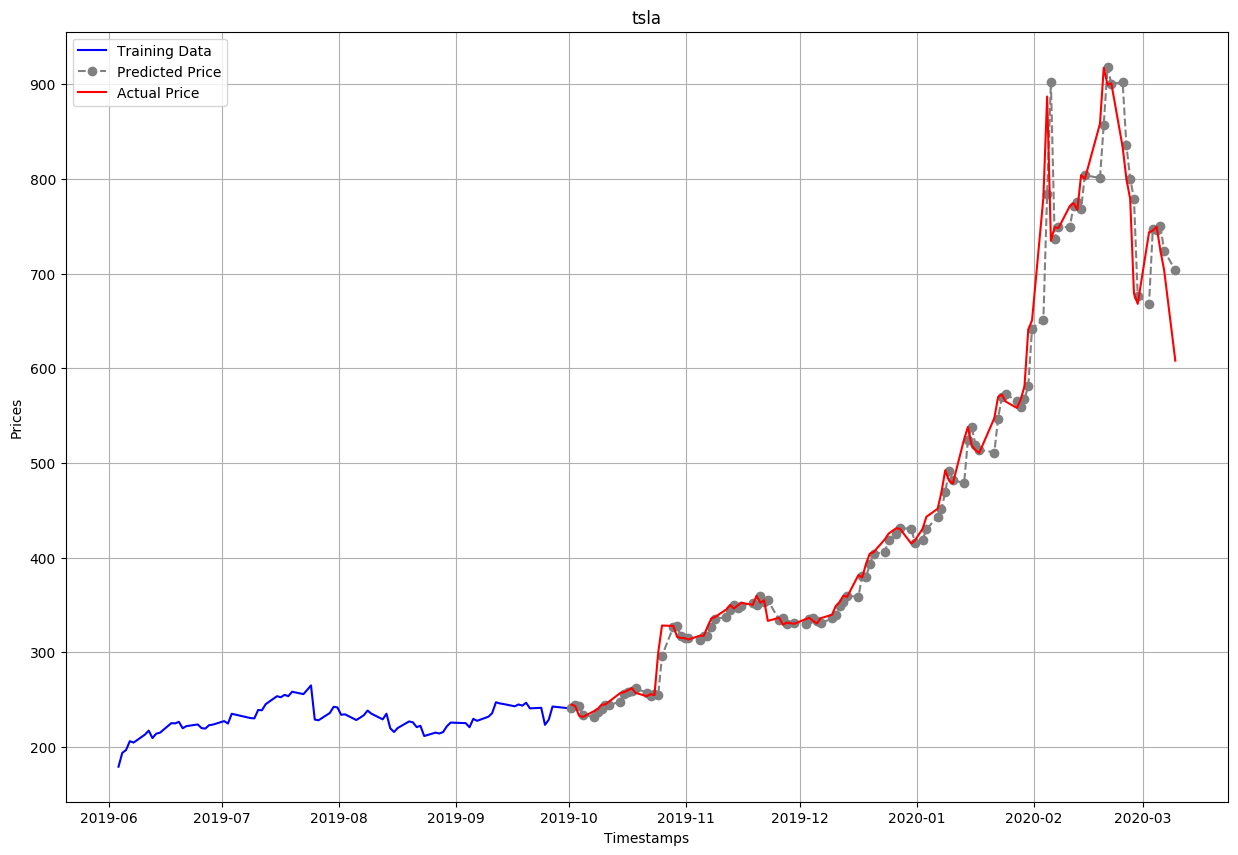

In [8]:
plt.figure(figsize=(15,10))

#Zoom in to predicted data
train_data[open_close] = sd.DatesRange(train_data[open_close], '2019-06-01')
test_data[open_close] = sd.DatesRange(test_data[open_close], '2019-06-01')

plt.plot(train_data[open_close], 'red', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='gray', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data[open_close], color='red', label='Actual Price')
plt.title(sd.get_stock())
plt.xlabel('Timestamps')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()
plt.grid()

In [9]:
print('Last Actual Price = ', sd.quote(sd.get_stock()).close[0])
print('Prediction for Next Price = ', np.round(PredictNextPrice(best_pdq),2))

Last Actual Price =  630.41
Prediction for Next Price =  603.2


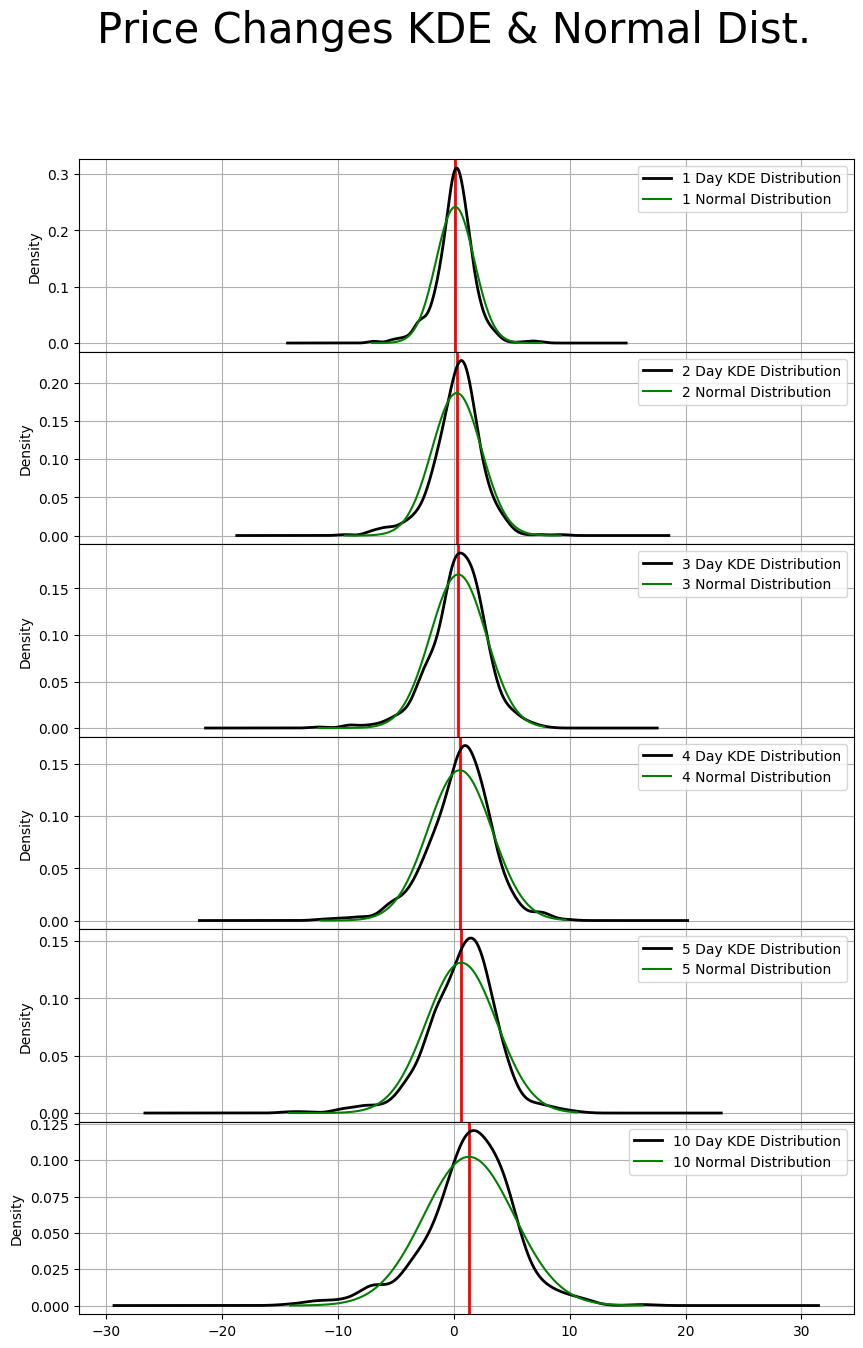

,Record Count,Mean of % Price Change,Std. Dev of % Price Change,Var of % Price Change,Max. % Price Rise,Max % Price Drop
index,,,,,,
1,548.0,0.122366,1.650887,2.725427,7.570531,-7.045899
2,547.0,0.253044,2.140960,4.583710,9.236314,-9.412407
3,546.0,0.384909,2.416660,5.840246,7.810230,-11.685727
4,545.0,0.522519,2.768429,7.664201,9.646192,-11.428414
5,544.0,0.653020,3.041833,9.252750,10.647545,-14.228395
10,539.0,1.311209,3.897795,15.192808,16.280506,-14.129154


In [10]:
sd.set_stock('msft')
open_close = 'AdjClose'
price_df = sd.GetStockDataFrame(sd.get_stock())
price_df = sd.DatesRange(price_df, '2018-01-01')
price_changes, stats = sd.PlotPriceChangesKDE(price_df,[1,2,3,4,5,10])
stats

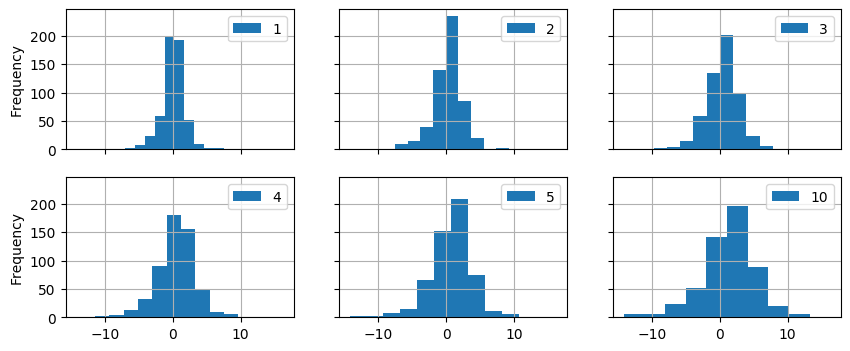

In [11]:
fig, ax = plt.subplots(2,3,figsize=(10,4),sharey=True,sharex=True)

price_changes[1].plot.hist(ax=ax[0,0]).grid(True)
price_changes[2].plot.hist(ax=ax[0,1]).grid(True)
price_changes[3].plot.hist(ax=ax[0,2]).grid(True)
price_changes[4].plot.hist(ax=ax[1,0]).grid(True)
price_changes[5].plot.hist(ax=ax[1,1]).grid(True)
price_changes[10].plot.hist(ax=ax[1,2]).grid(True)
_=[ax.legend(loc=1) for ax in plt.gcf().axes]

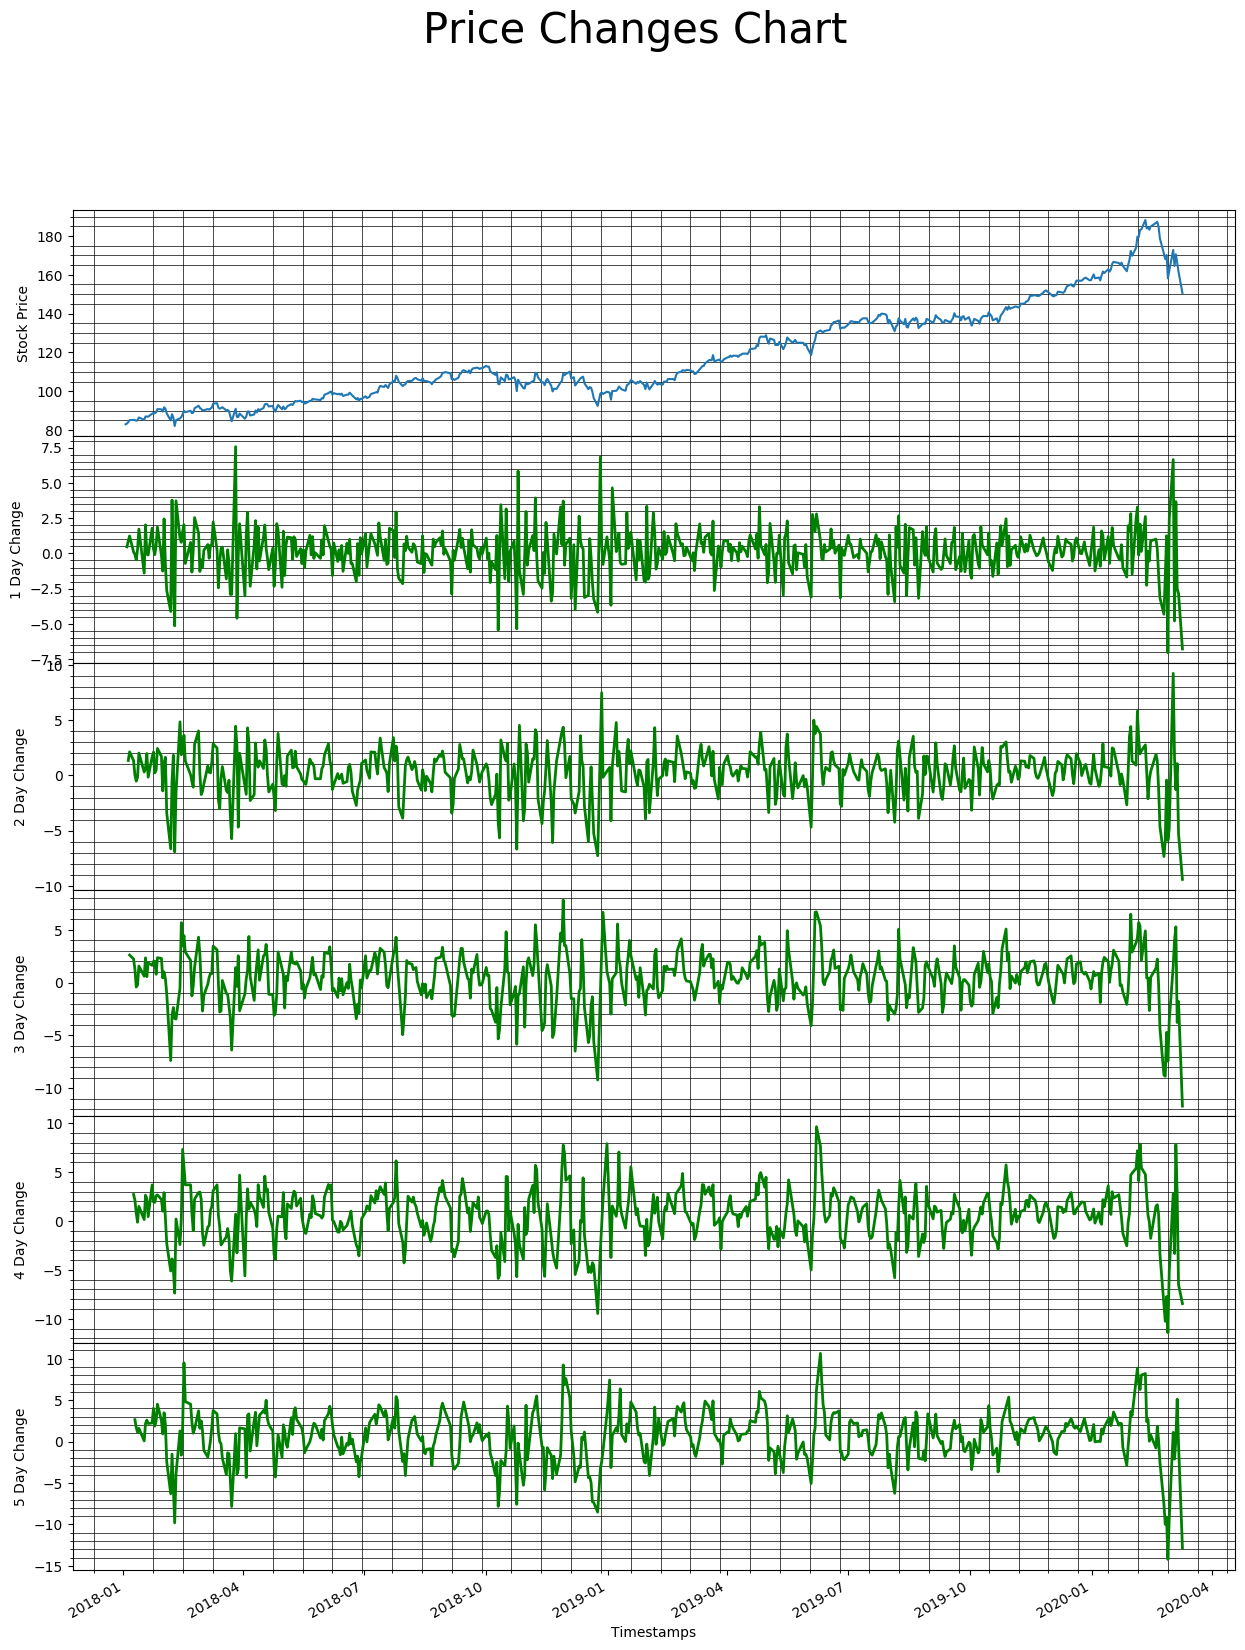

In [12]:
 sd.PlotPriceChangesPercent(price_df,[1,2,3,4,5])